### Preamble detection and frame/symbol synchronization

Preamble functions:
- Disturbance estimation
- Adjustment of receiver parameters
- Finding data frame beginning (frame recovery)
- Finding symbol position in received signals (symbol timing recovery)

In [217]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample_poly
from commpy.filters import rcosfilter
from commpy.channels import awgn

synch = [ 0, 3, 0 ,0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 3, 0, 0, 3, 3, 3, 0, 3, 3, 0, 0, 0, 3, 3, 0 ]
interp = resample_poly(synch, up=24, down=1)
SNR = 150
offset_change = -1

x = synch - np.mean(synch)
goldconv = np.correlate(x, x, mode="full")
N = len(x)
lagsgold = np.arange(-(N-1), N)

# Upsampling and SRRC filtering
x_int = interp - np.mean(interp)
goldconvupsample = np.correlate(x_int, x_int, mode="full")
beta = 0.35
sps = 1
t,h_rc = rcosfilter(N, beta, 1, sps)
goldconvupsamplerc = abs(np.convolve(goldconvupsample, h_rc, mode='same'))

# parameters for cfo
Fs = 1e6
f_offset = 1100  # Hz
n = np.arange(len(x_int))
cfo = np.exp(1j*2*np.pi*f_offset*n/Fs)

# Artificial signal
s_shift = np.roll(x_int, offset_change)
xdelta = (x_int * np.conj(s_shift))
sdelta=xdelta
xdelta = np.correlate(xdelta, xdelta, mode="full")

# Artificial signal with noise
r = awgn(x_int,SNR)

# Artificial signal with noise covariance
r_s = abs(np.correlate(r* cfo, x_int, mode="full"))

# Covariance of noisy signal with artificial signal
r_shift = np.roll(r, offset_change)
rdelta = (r * np.conj(r_shift))
rdelta = abs(np.correlate(sdelta, rdelta* cfo, mode="full"))

N = len(x_int)
lags = np.arange(-(N-1), N)

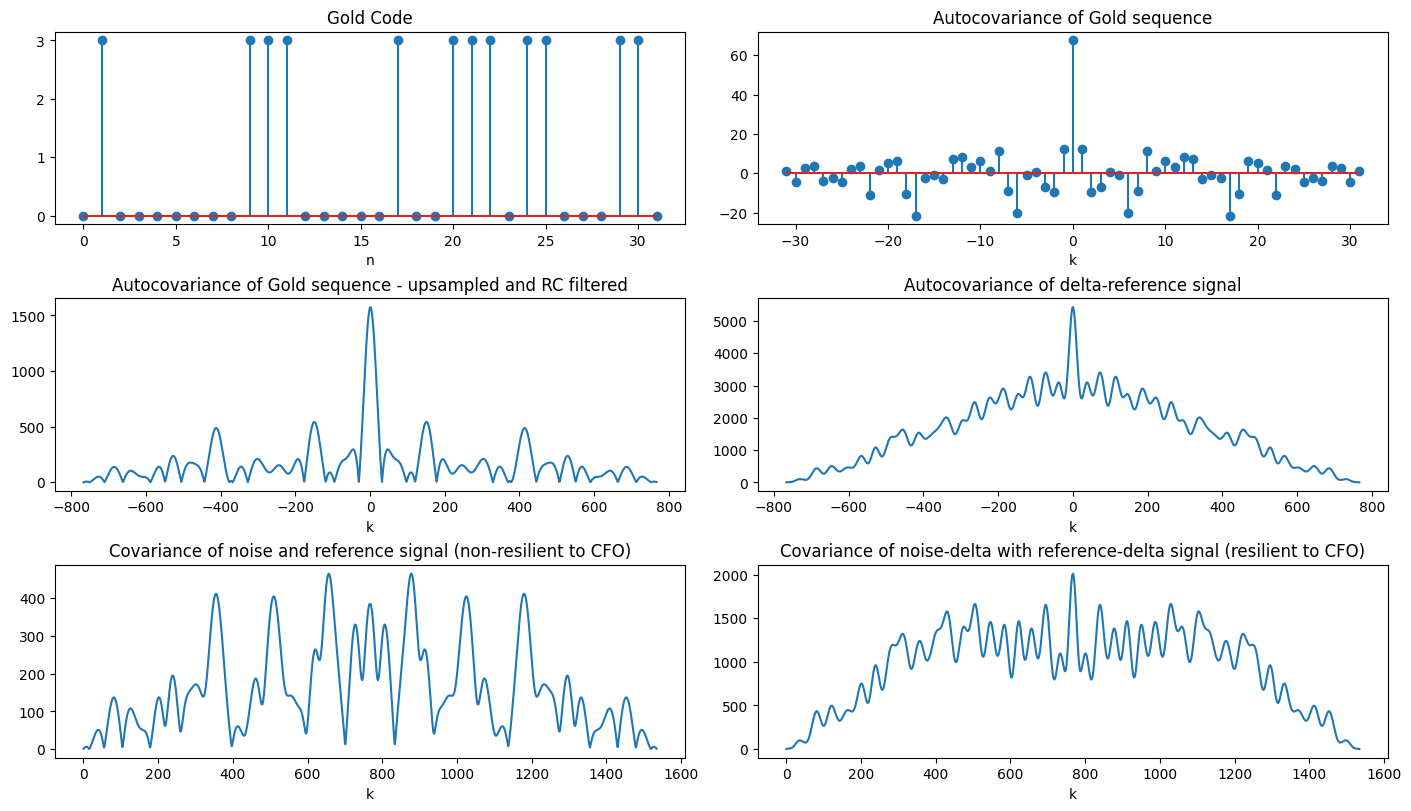

In [220]:
fig, ax = plt.subplots(3,2, figsize=(14, 8), constrained_layout=True)

ax[0,0].set_title("Gold Code")
ax[0,0].stem(synch)
ax[0,0].set_xlabel("n")

ax[0,1].set_title("Autocovariance of Gold sequence")
ax[0,1].stem(lagsgold,goldconv)
ax[0,1].set_xlabel("k")

ax[1,0].set_title("Autocovariance of Gold sequence - upsampled and RC filtered")
ax[1,0].plot(lags,goldconvupsamplerc)
ax[1,0].set_xlabel("k")

ax[1,1].set_title("Autocovariance of delta-reference signal")
ax[1,1].plot(lags,xdelta)
ax[1,1].set_xlabel("k")

ax[2,0].set_title("Covariance of noise and reference signal (non-resilient to CFO)")
ax[2,0].plot(r_s)
ax[2,0].set_xlabel("k")

ax[2,1].set_title("Covariance of noise-delta with reference-delta signal (resilient to CFO)")
ax[2,1].plot(rdelta)
ax[2,1].set_xlabel("k")
plt.show()